In [1]:
%reload_ext autoreload
%autoreload 2

See TM-score stats

,0
count,193933.000000
mean,0.585738
std,0.135622
min,0.170450
25%,0.489830
50%,0.587880
75%,0.680510
max,0.974390


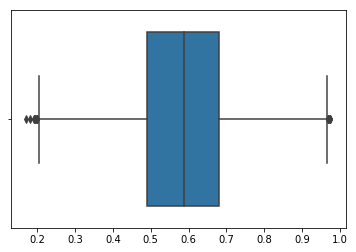

In [17]:
%matplotlib inline

from pathlib import Path
import pickle
import os
import sys
from concurrent.futures import ThreadPoolExecutor, as_completed

from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas
import seaborn
import itertools
from Bio.SCOP import Scop
from Bio import SeqIO

sys.path.append(Path().resolve().parent)
from machina.TMtoolsCommandLine import TMalignCommandLine


def process(c):
    tmalign = TMalignCommandLine(f'../data/train/pdbstyle-1.75/{c[0][2:4]}/{c[0]}.ent',
                                 f'../data/train/pdbstyle-1.75/{c[1][2:4]}/{c[1]}.ent')
    tmalign.run()
    return max(tmalign.tmscore)


def scop40_sf_hie():
    scop = Scop(dir_path='../data/train', version='1.75')
    result = {}
    for key in SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta'):
        domain = scop.getDomainBySid(key)
        if domain is None:
            assert key.startswith('g')
            continue
        sf = domain.getAscendent('sf')
        result.setdefault(sf.sccs, [])
        result[sf.sccs].append(key)
    return result

result_file = Path('../data/scop40_structural_alignment_stats.npy')
if not result_file.exists():
    hie = scop40_sf_hie()
    futures = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        for px in [_ for _ in hie if len(hie[_]) > 1]:
            for c in itertools.combinations(hie[px], 2):
                futures.append(executor.submit(process, c))
        result = [_.result() for _ in tqdm(as_completed(futures), total=len(futures))]
    np.save(result_file, np.array(result))

result = np.load(result_file)
result_df = pandas.DataFrame(result)
seaborn.boxplot(result_df)
result_df.describe()

Sort SCOP40 domains by superfamily size and revision date

These are candidates for test data, and others will be for training data.

In [4]:
from pathlib import Path
from datetime import datetime

from Bio import SeqIO
from Bio.PDB import PDBParser
from IPython.display import display
from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
import numpy as np

scop = Scop(dir_path='../data/train', version='1.75')
index = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
result = []
for key in tqdm(index):
    try:
        for line in Path(f'../data/train/pdbstyle-1.75/{key[2:4]}/{key}.ent').read_text().splitlines():
            if line.find('Source-PDB-REVDAT') > -1:
                domains = scop.getDomainBySid(key).getAscendent('sf').getDescendents('px')
                cl = scop.getDomainBySid(key).getAscendent('sf').sccs.split('.')[0]
                fl = scop.getDomainBySid(key).getAscendent('sf').sccs.split('.')[1]
                sf = scop.getDomainBySid(key).getAscendent('sf').sccs.split('.')[2]
                result.append((key,
                               datetime.strptime(line.split(':')[1].replace(' ', ''), '%d-%b-%y'),
                               cl, fl, sf,
                               len(domains)))
                break
    except FileNotFoundError:
        assert key.startswith('g')

result = sorted(result, key=lambda x: x[1], reverse=True)

test_dict = {}
for c in ['a', 'b', 'c', 'd', 'e', 'f', 'g']:
    test_dict[c] = []
    for r in [_ for _ in result if _[2] == c]:
        if len(test_dict[c]) == 7:
            break
        if r[3:5] not in [_[3:5] for _ in test_dict[c]]:
            if len([_ for _ in scop.getDomainBySid(r[0]).getAscendent('sf').getDescendents('px') if _.sid in index]) > 1:
                test_dict[c].append(r)
test_list = [__ for _ in test_dict.values() for __ in _[:5]]

old_test_data = (
    ('d1wlqc_', datetime(2009, 2, 17, 0, 0), 'a.4.5', 762),
    ('d2axtu1', datetime(2009, 2, 10, 0, 0), 'a.60.12', 159),
    ('d2zqna1', datetime(2009, 2, 10, 0, 0), 'b.42.2', 119),
    ('d1qg3a1', datetime(2009, 1, 20, 0, 0), 'b.1.2', 344),
    ('d1wzca1', datetime(2009, 1, 27, 0, 0), 'c.108.1', 296),
    ('d2dsta1', datetime(2009, 1, 27, 0, 0), 'c.69.1', 975),
    ('d1y5ha3', datetime(2009, 2, 10, 0, 0), 'd.37.1', 62),
    ('d2pzza1', datetime(2009, 1, 20, 0, 0), 'd.77.1', 92), # This is replaced by ('d2nwua1', (2009, 1, 20, 0, 0), 'd', '77', '1', 92)
    ('d1ni9a_', datetime(2009, 2, 10, 0, 0), 'e.7.1', 151),
    ('d3cw9a1', datetime(2008, 9, 2, 0, 0), 'e.23.1', 22),
    ('d2axtd1', datetime(2009, 2, 10, 0, 0), 'f.26.1', 174),
    ('d2axto1', datetime(2009, 2, 10, 0, 0), 'f.4.1', 15),
    ('d2vy4a1', datetime(2009, 2, 17, 0, 0), 'g.37.1', 182),
    ('d3d9ta1', datetime(2009, 2, 10, 0, 0), 'g.52.1', 81),
)

for t in old_test_data:
    if t[0] not in [_[0] for _ in test_list]:
        print(t)

display(test_list)

np.save('../data/test_domain_ids.npy', np.array([_[0] for _ in test_list]))

validate_gap_list = [__ for _ in test_dict.values() for __ in _[5:6]]
display(validate_gap_list)
np.save('../data/gap_validation_domain_ids.npy', np.array([_[0] for _ in validate_gap_list]))
validate_hyperparam_list = [_[6] for _ in test_dict.values()]
display(validate_hyperparam_list)
np.save('../data/hyperparam_validation_domain_ids.npy', np.array([_[0] for _ in validate_hyperparam_list]))


('d2pzza1', datetime.datetime(2009, 1, 20, 0, 0), 'd.77.1', 92)


[('d1wlqc_', datetime.datetime(2009, 2, 17, 0, 0), 'a', '4', '5', 762),
 ('d2axtu1', datetime.datetime(2009, 2, 10, 0, 0), 'a', '60', '12', 159),
 ('d2pqrb1', datetime.datetime(2009, 1, 27, 0, 0), 'a', '118', '8', 121),
 ('d3cr3a1', datetime.datetime(2009, 1, 20, 0, 0), 'a', '208', '1', 6),
 ('d2jn6a1', datetime.datetime(2009, 1, 6, 0, 0), 'a', '4', '1', 430),
 ('d2zqna1', datetime.datetime(2009, 2, 10, 0, 0), 'b', '42', '2', 119),
 ('d1qg3a1', datetime.datetime(2009, 1, 20, 0, 0), 'b', '1', '2', 344),
 ('d2a5za1', datetime.datetime(2009, 1, 20, 0, 0), 'b', '29', '1', 1081),
 ('d1wv3a1', datetime.datetime(2009, 1, 13, 0, 0), 'b', '26', '1', 73),
 ('d3etja1', datetime.datetime(2008, 12, 30, 0, 0), 'b', '84', '2', 68),
 ('d2w6ka1', datetime.datetime(2009, 2, 17, 0, 0), 'c', '151', '1', 4),
 ('d1wzca1', datetime.datetime(2009, 1, 27, 0, 0), 'c', '108', '1', 296),
 ('d1v7ra_', datetime.datetime(2009, 1, 27, 0, 0), 'c', '51', '4', 44),
 ('d2dsta1', datetime.datetime(2009, 1, 27, 0, 0), 'c',

[('d2ij2a1', datetime.datetime(2009, 1, 6, 0, 0), 'a', '104', '1', 242),
 ('d3d85d1', datetime.datetime(2008, 12, 23, 0, 0), 'b', '1', '1', 5565),
 ('d3etja2', datetime.datetime(2008, 12, 30, 0, 0), 'c', '30', '1', 194),
 ('d2iiza1', datetime.datetime(2009, 1, 6, 0, 0), 'd', '58', '4', 177),
 ('d1wuis1', datetime.datetime(2008, 6, 24, 0, 0), 'e', '19', '1', 34),
 ('d3dhwa1', datetime.datetime(2008, 8, 5, 0, 0), 'f', '58', '1', 12),
 ('d3d4ub1', datetime.datetime(2008, 9, 2, 0, 0), 'g', '9', '1', 62)]

[('d1tw9a1', datetime.datetime(2008, 12, 23, 0, 0), 'a', '45', '1', 511),
 ('d3e5ua2', datetime.datetime(2008, 12, 23, 0, 0), 'b', '82', '3', 91),
 ('d1xria_', datetime.datetime(2008, 12, 30, 0, 0), 'c', '45', '1', 189),
 ('d2jmua1', datetime.datetime(2009, 1, 6, 0, 0), 'd', '63', '1', 13),
 ('d2zd1b1', datetime.datetime(2008, 2, 12, 0, 0), 'e', '8', '1', 622),
 ('d2zfga1', datetime.datetime(2008, 7, 29, 0, 0), 'f', '4', '3', 101),
 ('d2vuti1', datetime.datetime(2008, 7, 29, 0, 0), 'g', '39', '1', 367)]

Generate structural alignments of SCOP40 domains in each superfamilies (by TM-align)

In [ ]:
from pathlib import Path
import sys

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_structural_alignment import generate_structural_alignments

# 90 min
generate_structural_alignments('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa',
                               '../data/train', '1.75', '../data/train/pdbstyle-1.75', '../data/train/scop40_structural_alignment.fasta')

In [7]:
import sys

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_sequence_profile import generate_sequence_profiles

generate_sequence_profiles('../data/train/scop40_structural_alignment.fasta', '../data/train/pssm')

100%|██████████| 9648/9648 [00:00<00:00, 41263.02it/s]


In [2]:
from pathlib import Path
import sys

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from tqdm import tqdm_notebook as tqdm

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import parse_pssm


results = []
seq_index = SeqIO.index('../data/train/scop40_structural_alignment.fasta', 'fasta')
for record_id in seq_index:
    l = record_id.split('&')
    results.append(l[0])
    results.append(l[1])

# Check alignments (20 min)
# All length of sequences of a domain must be the same.
for domain in tqdm(set(results)):
    try:
        MultipleSeqAlignment([SeqRecord(seq_index[_].seq.ungap('-'), id=_) for _ in seq_index if _.startswith(f'{domain}&')])
    except:
        print(domain)

# Check PSSM colmn length (20 min)
for domain in tqdm(set(results)):
    r = seq_index[[_ for _ in seq_index if _.startswith(f'{domain}&')][0]]
    len1 = len(r.seq.ungap('-'))
    len2 = len(parse_pssm(f'../data/train/pssm/{domain[2:4]}/{domain}.mtx').pssm)
    if len1 != len2:
        print(domain)

In [2]:
from pathlib import Path
import sys
import os

import numpy as np
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import create_scop40_dataset, split_data_label

masked_ids = np.load('../data/gap_validation_domain_ids.npy').tolist()
masked_ids.extend(np.load('../data/hyperparam_validation_domain_ids.npy').tolist())
masked_ids.extend(np.load('../data/test_domain_ids.npy').tolist())

# 80 min
create_scop40_dataset('../data/train/scop40_structural_alignment.fasta',
                      '../data/train/pssm', '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001.npy', 0.001, masked_ids)

split_data_label('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001.npy',
                 '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001_x.npy',
                 '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001_y.npy')

100%|██████████| 388946/388946 [1:26:54<00:00, 74.59it/s]
2019-03-28 01:49:29,710 [INFO] Training data shape=(214388, 201)
100%|██████████| 214388/214388 [00:00<00:00, 1011824.51it/s]


In [3]:
from pathlib import Path
import sys

import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.train import train_flann


train_flann(np.load('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001_x.npy'),
            '../data/train/flann19_scop40_logscore_tmscore0.5_window5_ratio0.001')

2019-03-28 10:07:23,265 [INFO] Indexing samples.shape = (214388, 200)...
2019-03-28 10:07:24,283 [INFO] Saving index...


# deprecated

In [ ]:
from Bio import SeqIO
import numpy as np

scop40_index = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
train_ids = np.load('../data/train/scop40_1fold.npy')
out = []
for t in train_ids:
    out.append(scop40_index[t])
SeqIO.write(out, 'data/blastdb/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75_train_only.fasta', 'fasta')

In [ ]:
from machina.conv_training_csv2npy import csv2npy_parted, csv2npy


csv2npy(200, 'data/train/scop40_logscore_tmscore50_w5')  # Needs > 40GB RAM

# csv2npy(360, 'data/train/scop40_tmscore50_w9')  # Needs > 200GB RAM
# csv2npy_parted(360, 'data/train/scop40_tmscore50_w9')
# csv2npy_parted(360, 'data/train/scop40_tmscore50_w9', n_part=3, n_sample=396540456)

In [2]:
import numpy as np

from machina.reduce_training_dataset import random_sampling, negative_down_sampling


# negative_down_sampling('data/train/scop40_tmscore50_w9', 3)

ratio = 0.01
print(ratio)
random_sampling('data/train/scop40_logscore_tmscore50_w5', ratio)
X = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_x.npy')
print(X.shape)
Y = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_y.npy')
print(Y.shape)
print(np.argwhere(Y == 1).shape)
print(np.argwhere(Y == 0).shape)

ratio = 0.1
print(ratio)
random_sampling('data/train/scop40_logscore_tmscore50_w5', ratio)
X = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_x.npy')
print(X.shape)
Y = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_y.npy')
print(Y.shape)
print(np.argwhere(Y == 1).shape)
print(np.argwhere(Y == 0).shape)

0.01
(2150375, 200)
(2150375,)
(176007, 1)
(1974368, 1)
0.1
(21503756, 200)
(21503756,)
(1763022, 1)
(19740734, 1)


In [3]:
from pathlib import Path
import pickle

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

from machina.generate_training_dataset import get_validation_data


db_index = SeqIO.index('data/train/scop40_structural_alignment.fasta', 'fasta')
scop_root = Scop(dir_path=Path('data/scop'), version='1.75')
test_data = np.load('data/test/scop40.npy')
with Path('data/train/scop40_hie.pkl').open('rb') as f:
    hie = pickle.load(f)

for t in tqdm(test_data):
    Path(f'data/test/{t}').mkdir(exist_ok=True)
    query_sf_sunid = scop_root.getDomainBySid(t).getAscendent('sf').sunid
    for d in hie[query_sf_sunid]:
        x, y = get_validation_data(t, d, db_index, 5, 0)
        np.save(f'data/test/{t}/{d}_x.npy', x)
        np.save(f'data/test/{t}/{d}_y.npy', y)

# Check shapes
for t in tqdm(test_data):
    query_sf_sunid = scop_root.getDomainBySid(t).getAscendent('sf').sunid
    for d in hie[query_sf_sunid]:
        x = np.load(f'data/test/{t}/{d}_x.npy')
        y = np.load(f'data/test/{t}/{d}_y.npy')
        assert x.shape[0] == y.shape[0] * y.shape[1]


In [ ]:
from generate_training_dataset import *
import itertools

from matplotlib import pyplot
import numpy as np
from IPython.display import display

pssm1 = parse_pssm('tests/data/pssm/1dlwa_.mtx')
pssm2 = parse_pssm('tests/data/pssm/7hbia_.mtx')
msa = parse_alignment('d1dlwa_', 'd7hbia_')

rec, win = create_dataset(pssm1, pssm2, msa, Path('/dev/null').open('w'))

pyplot.figure(figsize=(len(msa[0].seq.ungap('-'))*0.25, len(msa[1].seq.ungap('-'))*0.25))
x, y = [0], [0]
for i in range(msa.get_alignment_length()):
    pyplot.axes().add_patch(pyplot.Rectangle((x[-1]-WINDOW_CENTER, y[-1]-WINDOW_CENTER),
                                             WINDOW_WIDTH, WINDOW_WIDTH,
                                             fill=False, color='green', alpha=1.0))
    for a, b in itertools.product(range(WINDOW_WIDTH), range(WINDOW_WIDTH)):
        if rec[i][a][b] is not None:
            pyplot.axes().add_patch(
                pyplot.Circle((x[-1]-WINDOW_CENTER+a+0.5, y[-1]-WINDOW_CENTER+b+0.5),
                              radius=0.5, alpha=0.2, color='red'))
        if win[i][a][b] == 1:
            pyplot.axes().add_patch(
                pyplot.Circle((x[-1]-WINDOW_CENTER+a+0.5, y[-1]-WINDOW_CENTER+b+0.5),
                              radius=0.5, alpha=0.2, color='blue'))
    if msa[0][i] == "-":
        x.append(x[-1])
        y.append(y[-1] + 1)
    elif msa[1][i] == "-":
        x.append(x[-1] + 1)
        y.append(y[-1])
    else:
        x.append(x[-1] + 1)
        y.append(y[-1] + 1)
pyplot.yticks(np.arange(-5, len(msa[1].seq.ungap('-'))+5, 1))
pyplot.xticks(np.arange(-5, len(msa[0].seq.ungap('-'))+5, 1))
pyplot.grid(color='gray', linestyle='-')
pyplot.plot(np.array(x), np.array(y))
pyplot.show()